## Import libraries and data

##### Dom Ong
Role: 

In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
import plotly.express as px
import contextily as ctx
import plotly.io as pio
import statistics
import plotly.graph_objects as go

In [10]:
# Set working directory
cwd = os.getcwd()
print('Current Working Directory is: ', cwd)

Current Working Directory is:  /Users/dominiqueong/Documents/CCED


## Rent Stabilized Ordinance Units

Rental units covered under the Rent Stabilization Ordinance (RSO) have rent control protections, eviction protections, and relocation assistance.

Generally, the RSO applies to rental units built on or before October 1, 1978 or newly-constructed units that replace demolish RSO rental units.

### Relevance to Research Question

Mapping RSO units illustrates the scarcity of affordable housing and tenant protections against unjust evictions.

In [168]:
# Import rental units under RSO from 2016-2022 from LAHD/HCID dashboard
rso_path = os.path.join("RSO","rso cpra workbook 2016-2023.csv")
rso = pd.read_csv(rso_path,dtype={'APN':str,'Zip':str})

### Spatial Join RSO Data to Parcel Geographic Boundaries by Merging on APN Attribute

In [235]:
# Import parcel geographic boundaries downloaded from LA County GIS Hub, clipped to Chinatown boundary using ArcPro
parcels_path = os.path.join("LA_County_Parcels_Feature_Clip.zip")
parcels = gpd.read_file(parcels_path,dtype={'APN':str})
# Remove hyphen from strings in APN column
parcels['APN'] = parcels['APN'].str.replace('-', '')
# Merge to join RSO dataframe and parcel geodataframe
rso_parcels = parcels.merge(rso, on='APN')

In [292]:
# Trim columns in the merged RSO geodataframe
desired_columns = ['APN','SitusFullA','geometry','YearBuilt1','Units1','RSO Year','RSO Units']
rso_parcels = rso_parcels[desired_columns].copy()
rso_parcels.head(5)

,APN,SitusFullA,geometry,YearBuilt1,Units1,RSO Year,RSO Units
0,5407022001,734 N HILL PL LOS ANGELES CA 90012,"POLYGON Z ((-118.24245 34.06255 0.00000, -118....",1965,2,2021,2
1,5407022001,734 N HILL PL LOS ANGELES CA 90012,"POLYGON Z ((-118.24245 34.06255 0.00000, -118....",1965,2,2020,2
2,5407022001,734 N HILL PL LOS ANGELES CA 90012,"POLYGON Z ((-118.24245 34.06255 0.00000, -118....",1965,2,2022,2
3,5407022001,734 N HILL PL LOS ANGELES CA 90012,"POLYGON Z ((-118.24245 34.06255 0.00000, -118....",1965,2,2023,2
4,5407022001,734 N HILL PL LOS ANGELES CA 90012,"POLYGON Z ((-118.24245 34.06255 0.00000, -118....",1965,2,2019,2


In [245]:
# Find the number of unique parcels with RSO units 
print(len(rso_parcels['APN'].unique()))
# Find the range of RSO rental units in each parcels, sorted by descending order
rso_unit_range = sorted(rso_parcels['RSO Units'].unique())
# Find the parcels with the highest number of RSO rental units
rso_unit_1 = rso_parcels[rso_parcels['RSO Units']==rso_unit_range[-1]]
rso_unit_2 = rso_parcels[rso_parcels['RSO Units']==rso_unit_range[len(rso_unit_range)-2]]
rso_unit_3 = rso_parcels[rso_parcels['RSO Units']==rso_unit_range[len(rso_unit_range)-3]]

276


##### Metadata
There are 276 parcels in Chinatown that had or have RSO Units between 2016-2023.
Parcels vary in the number of RSO rental units
The highest number of RSO units were 38, 55, and 123 units. These units were located at 946 YALE ST (APN 5414006027) with 38 units, 734 YALE ST (APN 5408018028) with 55 units, and 808 N SPRING ST (APN 5408029005) with 123 units.

### Identify parcels in Chinatown that lost ALL RSO units between 2016 and 2023

In [265]:
# Define a function to find parcels missing from current year of RSO data
def all_rso_loss(parcel_data):
    # Get number of years in parcel data
    years = parcel_data['RSO Year'].unique()
    # Sort years by descending order
    years_list = sorted(years)
    # Get the first year
    years_begin = years_list[0]
    # Get the last year
    years_end = years_list[-1]
    # Filter data to first year
    parcels_begin = parcel_data[parcel_data['RSO Year']==years_begin]
    # Filter data to last year
    parcels_end = parcel_data[parcel_data['RSO Year']==years_end]
    # Find parcels in first year of data but not in last year of data
    apn_diff = np.setdiff1d(parcels_begin['APN'],parcels_end['APN'])
    apn_diff = apn_diff.tolist()
    # Filter first year of parcel data
    # Only include parcels in first year of RSO data but not in last year of RSO data
    rso_diff = parcel_data[parcel_data['APN'].isin(apn_diff)]
    rso_diff_sorted = rso_diff.sort_values(by=['APN','RSO Year'])
    return rso_diff_sorted[rso_diff_sorted['RSO Year']==years_begin]

In [272]:
# Call function to identify parcels in Chinatown that lost all RSO units between 2016 and 2023
# Find parcels that had RSO units in 2016 but NOT in 2023
parcels_all_rso_loss = all_rso_loss(rso_parcels)
# Count how many parcels lost all RSO units
len(parcels_all_rso_loss['APN'].unique())
# Sum number of RSO units were in parcels that lost all RSO units
parcels_all_rso_loss['RSO Units'].sum()

191

##### Metadata
Between 2016 and 2023, 9 parcels lost all their RSO units. A total of 191 RSO units were lost.

### Identify parcels in Chinatown that lost some BUT NOT ALL RSO units between 2016 and 2023

In [312]:
# Subset by year 2016
rso_2016 = rso_parcels[rso_parcels['RSO Year']==2016]
# Trim to only include APN and RSO Units columns
columns_names = ['APN','RSO Units']
rso_2016_trim = rso_2016[columns_names].copy()
rso_2016_trim.columns = ['APN','RSO Units 2016']
# # Subset by year 2023
rso_2023 = rso_parcels[rso_parcels['RSO Year']==2023]
# Merge 2016 and 2023 dataframes on APN attribute
rso_change = rso_2023.merge(rso_2016_trim,on="APN")
# Create a new column in merged dataframe, populate this column with diffence between 2016 and 2023 RSO units
rso_change['RSO Change'] = rso_change['RSO Units'] - rso_change['RSO Units 2016'] 
# Calculate number of parcels that did not lose any RSO units
num_rso_same = len(rso_change[rso_change['RSO Change']==0])
print(num_rso_same)
# Calculate number of parcels that lost RSO units between 2016-2023
num_rso_loss = len(rso_change[rso_change['RSO Change']<0])
print(num_rso_loss)

253
8


##### Metadata
From 2016 to 2013, most parcels did not experience a change in the number of RSO units (238 parcels had  a difference of 0). 8 parcels saw a loss in RSO rental units.

### Map parcels with RSO units over time

#### Purpose of Visualization
This map illustrates changes in the spatial extent and quantity of parcels with RSO units in 2016 and 2023 in Chinatown. The map compares RSO units in 2016 and 2023 by placing two maps of each year side by side.

Both maps show parcels with RSO units in black fill and parcels that lost all RSO units in a thick red outline.

The 2023 map highlights parcels that lost some but not all RSO units in red fill.

#### Key Takeways from Visualization
From 2016-2023, several parcels in Chinatown lost at least some RSO units. 8 parcels saw a loss in RSO rental units while 9 parcels lost all their RSO units.

Parcels where RSO was eliminated altogether (e.g., loss of all RSO units) were big buildings with large numbers of units. Their conversion meant a loss of almost 200 RSO units in Chinatown.

<AxesSubplot:title={'center':'2023'}>

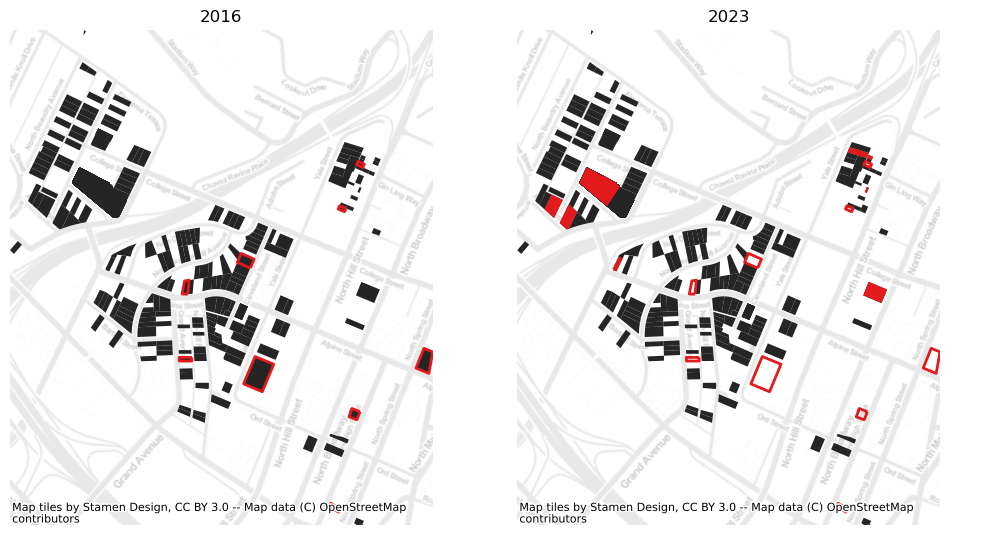

In [343]:
# Set axis limits based on 2016 RSO data extent
minx, miny, maxx, maxy = rso_parcels[rso_parcels['RSO Year']==2016].total_bounds

# Create choropleth map of parcels by change in number of RSO units from 2016-2023   
fig, ax = plt.subplots(1,2,figsize=(12,10))
# Plot parcels with RSO units in 2016
rso_parcels[rso_parcels['RSO Year']==2016].plot(ax=ax[0],color='#252525')
ax[0].axis('off')
ax[0].set_title('2016')
ax[0].set_xlim(minx, maxx)
ax[0].set_ylim(miny, maxy)
ctx.add_basemap(ax[0], source=ctx.providers.Stamen.TonerLite,crs=4326,alpha=0.2)

# Plot parcels that lost all RSO units in red outline
parcels_all_rso_loss[parcels_all_rso_loss['RSO Year']==2016].plot(ax=ax[0],facecolor="none",edgecolor='#e31a1c',linewidth=2)

# Plot parcels with RSO units in 2023
rso_parcels[rso_parcels['RSO Year']==2023].plot(ax=ax[1],color='#252525')
ax[1].axis('off')
ax[1].set_title('2023')
ax[1].set_xlim(minx, maxx)
ax[1].set_ylim(miny, maxy)
ctx.add_basemap(ax[1], source=ctx.providers.Stamen.TonerLite,crs=4326,alpha=0.2)

# Plot parcels that lost some RSO units in red fill
rso_change[rso_change['RSO Change']<0].plot(ax=ax[1],color='#e31a1c',linewidth=2)

# Plot parcels that lost all RSO units in red outline
parcels_all_rso_loss[parcels_all_rso_loss['RSO Year']==2016].plot(ax=ax[1],facecolor="none",edgecolor='#e31a1c',linewidth=2)


## Infrastructure Investments and Market-Rate Developments 

### Relevance to Research Question
Green gentrification is associated with public investments in transit and parks. Mapping and overlaying the locations of the Chinatown Metro Station (opened in 2003) and the LA State Historic Park (opened in 2017) may help us better understand changes in land use and housing availability in Chinatown.

In [354]:
# Import Chinatown neighborhood boundary geojson file directly from source
chinatown_neighborhood = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?where=name%20%3D%20'CHINATOWN'&outFields=*&outSR=4326&f=geojson")
# Import Chinatown Metro Station geojson file directly from LA City GeoHub source
chinatown_metro = gpd.read_file("https://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/LMS_Data_Public/MapServer/185/query?where=Name%20%3D%20'CHINATOWN%20METRO%20STATION'&outFields=*&outSR=4326&f=geojson")
# Import LA State Historic Park geojson file directly from LA City GeoHub source
la_hist_park = gpd.read_file("https://services1.arcgis.com/X1hcdGx5Fxqn4d0j/arcgis/rest/services/Conservation_Lands/FeatureServer/1/query?where=UNITNAME%20%3D%20'LOS%20ANGELES%20SHP'&outFields=*&outSR=4326&f=geojson")

In [356]:
# Create a dataframe with existing market-rate developments in Chinatown based on CCED's previous research
gentrifiers = pd.DataFrame({'Development': ['Jia Apartments', 'Blossom Plaza', '211 W Alpine', 'Harmony Project', '843 Spring'],
     'APN': ['5408016002', '5414013901', '5408030035', '5414013014', '5408031015']})
# Merge dataframe of existing market-rate developments with parcel geodataframe
existing_dev_parcels = parcels.merge(gentrifiers,on='APN')

### Map of Chinatown Metro Station and LA State Historic Park

<AxesSubplot:>

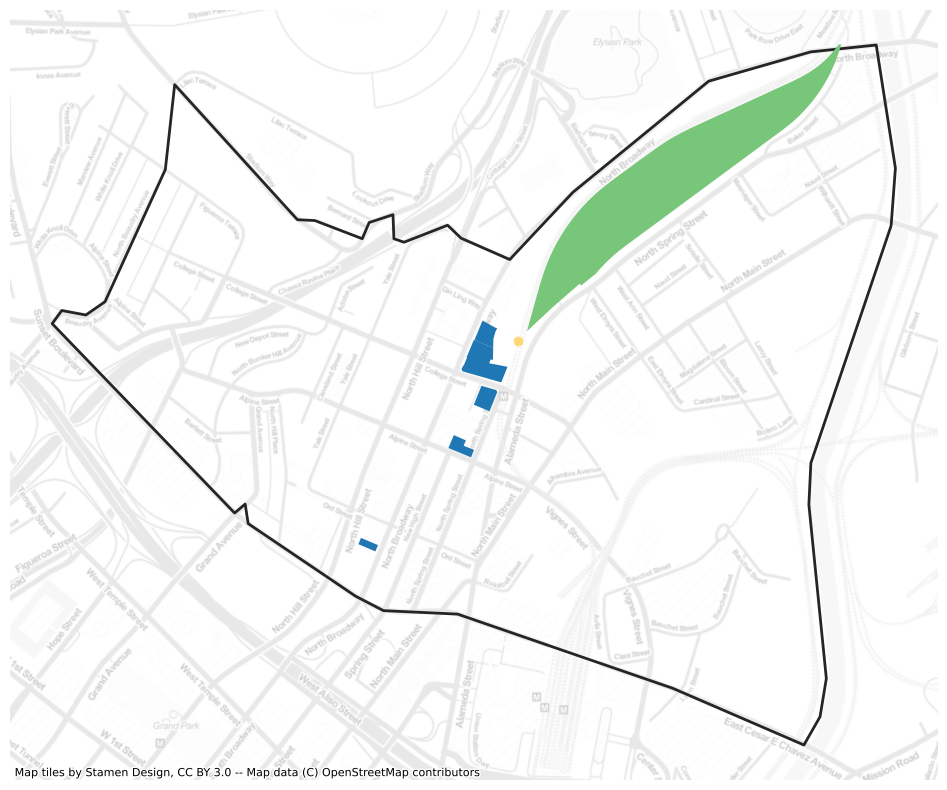

In [358]:
# Create choropleth map of parcels by change in number of RSO units from 2016-2023   
fig, ax = plt.subplots(figsize=(12,10))
# Plot Chinatown neighborhood boundaries
chinatown_neighborhood.plot(ax=ax,facecolor='none',edgecolor='#252525',linewidth=2)
ax.axis('off')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite,crs=4326,alpha=0.2)
# Plot Chinatown Metro Station
chinatown_metro.plot(ax=ax,color='#fed976')
# Plot LA State Historic Park
la_hist_park.plot(ax=ax,color='#78c679')
# Plot existing market-rate developments
existing_dev_parcels.plot(ax=ax)